#Implémentation DQN et DDQN avec CNN

##Library

In [ ]:
pip install gymnasium[atari]==0.29.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.2 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.10.1
    Uninstalling ale-py-0.10.1:
      Successfully uninstalled ale-py-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.8.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


In [ ]:
pip install gymnasium[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446667 sha256=e0273b16fdfb2fd0bb36e90147ef4b38d479b2ae7f67b693a5761b66c70e30b7
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license


In [ ]:
pip install gymnasium[atari] ale-py

In [ ]:
#Liste et affiche les environnements enregistrés dans Gymnasium

import gymnasium as gym
envs = gym.envs.registry
for env_spec in sorted(envs):
    print(env_spec)


ALE/Adventure-ram-v5
ALE/Adventure-v5
ALE/AirRaid-ram-v5
ALE/AirRaid-v5
ALE/Alien-ram-v5
ALE/Alien-v5
ALE/Amidar-ram-v5
ALE/Amidar-v5
ALE/Assault-ram-v5
ALE/Assault-v5
ALE/Asterix-ram-v5
ALE/Asterix-v5
ALE/Asteroids-ram-v5
ALE/Asteroids-v5
ALE/Atlantis-ram-v5
ALE/Atlantis-v5
ALE/Atlantis2-ram-v5
ALE/Atlantis2-v5
ALE/Backgammon-ram-v5
ALE/Backgammon-v5
ALE/BankHeist-ram-v5
ALE/BankHeist-v5
ALE/BasicMath-ram-v5
ALE/BasicMath-v5
ALE/BattleZone-ram-v5
ALE/BattleZone-v5
ALE/BeamRider-ram-v5
ALE/BeamRider-v5
ALE/Berzerk-ram-v5
ALE/Berzerk-v5
ALE/Blackjack-ram-v5
ALE/Blackjack-v5
ALE/Bowling-ram-v5
ALE/Bowling-v5
ALE/Boxing-ram-v5
ALE/Boxing-v5
ALE/Breakout-ram-v5
ALE/Breakout-v5
ALE/Carnival-ram-v5
ALE/Carnival-v5
ALE/Casino-ram-v5
ALE/Casino-v5
ALE/Centipede-ram-v5
ALE/Centipede-v5
ALE/ChopperCommand-ram-v5
ALE/ChopperCommand-v5
ALE/CrazyClimber-ram-v5
ALE/CrazyClimber-v5
ALE/Crossbow-ram-v5
ALE/Crossbow-v5
ALE/Darkchambers-ram-v5
ALE/Darkchambers-v5
ALE/Defender-ram-v5
ALE/Defender-v5
ALE/

In [ ]:
import gymnasium as gym
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
from itertools import count
import matplotlib.pyplot as plt
from itertools import zip_longest


#Replay Memory and Transitio

In [ ]:

# Définir le device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transition pour Replay Memory
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Classe Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN with CNN

In [ ]:
# Réseau DQN
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2)

        # Calcul de la taille après les convolutions
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 64
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return self.head(x.view(x.size(0), -1))

## Pré-traitement des observations

In [ ]:
def preprocess_observation(observation):
    """
    Prétraite une observation en la redimensionnant, normalisant et la convertissant en un tenseur PyTorch.

    Args:
    - observation (numpy.ndarray): L'image d'observation représentant l'état de l'environnement.

    Returns:
    - torch.Tensor: Un tenseur PyTorch de la forme (1, canaux, hauteur, largeur) représentant l'observation prétraitée.
    """

    import cv2
    resized = cv2.resize(observation, (84, 84))
    normalized = resized / 255.0
    return torch.tensor(normalized, device=device, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

##Epsilon-Greedy

In [ ]:
# Stratégie epsilon-greedy pour sélectionner les actions
def select_action(state, policy_net, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY):
    """
    Sélectionne une action à partir de l'état actuel en utilisant une stratégie epsilon-greedy.

    Args:
    - state (torch.Tensor): L'état actuel de l'environnement, représenté par un tenseur.
    - policy_net (torch.nn.Module): Le réseau de politique utilisé pour prédire les valeurs des actions possibles.
    - n_actions (int): Le nombre total d'actions possibles dans l'environnement.
    - steps_done (int): Le nombre d'étapes effectuées jusqu'à présent, utilisé pour ajuster epsilon.
    - EPS_START (float): La valeur initiale d'epsilon (probabilité d'explorer).
    - EPS_END (float): La valeur finale d'epsilon (probabilité d'exploiter).
    - EPS_DECAY (int): Le nombre d'étapes nécessaires pour faire décroitre epsilon de `EPS_START` à `EPS_END`.

    Returns:
    - torch.Tensor: La sélection de l'action sous forme de tenseur.
    """

    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

## Optimisation du modèle

In [ ]:
def optimize_model(policy_net, target_net, memory, optimizer, BATCH_SIZE, GAMMA, use_ddqn):
    """
    Optimise le modèle en utilisant la méthode de Q-learning avec DQN ou DDQN.

    Args:
    - policy_net (torch.nn.Module): Le réseau de politique (DQN) qui est optimisé.
    - target_net (torch.nn.Module): Le réseau cible, qui est utilisé pour fournir les valeurs d'estimation des états suivants.
    - memory (ReplayMemory): Le tampon de mémoire (ReplayMemory) contenant les transitions de l'environnement pour l'apprentissage.
    - optimizer (torch.optim.Optimizer): L'optimiseur utilisé pour mettre à jour les poids du réseau de politique.
    - BATCH_SIZE (int): Le nombre d'échantillons utilisés dans chaque mise à jour du modèle.
    - GAMMA (float): Le facteur de discount pour la récompense future dans l'équation de Bellman.
    - use_ddqn (bool): Un indicateur de la méthode utilisée, True pour DDQN (Double DQN), False pour DQN standard.
    """

    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        if use_ddqn:
            next_actions = policy_net(non_final_next_states).max(1).indices
            next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        else:
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

#train data

In [ ]:
def train_episode(env, policy_net, target_net, optimizer, memory, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA, TAU, use_ddqn):
    """
    Entraîne l'agent pour un épisode dans l'environnement en suivant la stratégie epsilon-greedy.

    Args:
    - env (gym.Env): L'environnement d'entraînement de l'agent (ex. OpenAI Gym).
    - policy_net (torch.nn.Module): Le réseau de politique (DQN) utilisé pour sélectionner les actions.
    - target_net (torch.nn.Module): Le réseau cible, utilisé pour estimer la valeur des actions futures.
    - optimizer (torch.optim.Optimizer): L'optimiseur utilisé pour mettre à jour les poids du réseau de politique.
    - memory (ReplayMemory): La mémoire de replay utilisée pour stocker les transitions (état, action, récompense, état suivant).
    - n_actions (int): Le nombre d'actions possibles dans l'environnement.
    - steps_done (int): Le nombre total d'étapes effectuées jusque-là, utilisé pour gérer l'epsilon-greedy.
    - EPS_START (float): La valeur initiale de epsilon pour la stratégie epsilon-greedy.
    - EPS_END (float): La valeur finale de epsilon pour la stratégie epsilon-greedy.
    - EPS_DECAY (float): Le taux de décroissance de epsilon.
    - BATCH_SIZE (int): La taille du lot utilisée pour la mise à jour des poids.
    - GAMMA (float): Le facteur de discount pour les récompenses futures.
    - TAU (float): Le facteur de mise à jour des poids du réseau cible (soft update).
    - use_ddqn (bool): Si True, utilise la technique DDQN (Double DQN), sinon utilise le DQN classique.

    Returns:
    - total_reward (float): La récompense totale accumulée durant l'épisode.
    - q_values (list): La liste des valeurs Q estimées pour chaque état de l'épisode.
    - rewards (list): La liste des récompenses cumulées à chaque étape de l'épisode.
    """

    state, _ = env.reset()
    state = preprocess_observation(state)

    total_reward = 0
    q_values = []
    rewards=[]
    iteration=0
    for t in count():
        action = select_action(state, policy_net, n_actions, steps_done, EPS_START, EPS_END, EPS_DECAY)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        next_state = None if done else preprocess_observation(observation)

        memory.push(state, action, next_state, reward)
        state = next_state
        total_reward += reward.item()
        rewards.append(total_reward)
        iteration+=1

        if len(memory) >= BATCH_SIZE:
            optimize_model(policy_net, target_net, memory, optimizer, BATCH_SIZE, GAMMA, use_ddqn)

        with torch.no_grad():
            for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
                target_param.data.copy_(policy_param.data * TAU + target_param.data * (1.0 - TAU))

        with torch.no_grad():
            if state is not None:
                q_value = policy_net(state).max(1)[0].item()
                q_values.append(q_value)
        if done:
            break

    return total_reward,q_values,rewards

##plotting for training step

In [ ]:
def pad_sequences(data, fill_value=np.nan):
    """
    Convertit des listes de longueurs variables en un tableau NumPy avec un padding
    pour égaliser les longueurs des séquences.

    Args:
    - data (list of lists): Liste de séquences de longueurs variées à compléter.
    - fill_value (optional, default=np.nan): La valeur de remplissage utilisée pour
      égaliser les séquences plus courtes. Par défaut, cette valeur est NaN.

    Returns:
    - np.ndarray: Un tableau NumPy contenant les séquences égalisées avec le padding.
    """
    return np.array(list(zip_longest(*data, fillvalue=fill_value))).T


def plot_results(scores_dqn_runs, scores_ddqn_runs, q_values_dqn_run, q_values_ddqn_run):
    """
    Affiche les résultats d'entraînement pour les modèles DQN et DDQN, y compris les scores et les Q-values,
    avec des courbes de médiane et des intervalles de confiance (25e et 75e percentiles).

    Cette fonction génère deux graphiques côte à côte :
    - Le premier montre l'évolution des scores de performance de l'agent DQN et DDQN, avec des intervalles de confiance.
    - Le deuxième affiche les Q-values médianes des deux modèles avec des intervalles de confiance.

    Args:
    - scores_dqn_runs (list of list): Scores des différentes exécutions pour le modèle DQN. Chaque sous-liste correspond
      aux scores d'une exécution.
    - scores_ddqn_runs (list of list): Scores des différentes exécutions pour le modèle DDQN. Chaque sous-liste correspond
      aux scores d'une exécution.
    - q_values_dqn_run (list of list): Q-values au cours de l'entraînement pour le modèle DQN. Chaque sous-liste correspond
      aux Q-values d'une exécution.
    - q_values_ddqn_run (list of list): Q-values au cours de l'entraînement pour le modèle DDQN. Chaque sous-liste correspond
      aux Q-values d'une exécution.

    """
    #print("scores_dqn_runs",scores_dqn_runs)

    # Appliquer le padding aux Q-values
    q_values_dqn_run = pad_sequences(q_values_dqn_run)
    q_values_ddqn_run = pad_sequences(q_values_ddqn_run)
    scores_dqn_runs = pad_sequences(scores_dqn_runs)
    scores_ddqn_runs = pad_sequences(scores_ddqn_runs)
    #scores
    median_dqn = np.nanmedian(scores_dqn_runs, axis=0)
    lower_dqn = np.nanpercentile(scores_dqn_runs, 25, axis=0)
    upper_dqn = np.nanpercentile(scores_dqn_runs, 75, axis=0)

    median_ddqn = np.nanmedian(scores_ddqn_runs, axis=0)
    lower_ddqn = np.nanpercentile(scores_ddqn_runs, 25, axis=0)
    upper_ddqn = np.nanpercentile(scores_ddqn_runs, 75, axis=0)
    #q_values

    # Calculer les médianes en ignorant les NaN
    median_dqn_q = np.nanmedian(q_values_dqn_run, axis=0)
    lower_dqn_q = np.nanpercentile(q_values_dqn_run, 25, axis=0)
    upper_dqn_q = np.nanpercentile(q_values_dqn_run, 75, axis=0)

    median_ddqn_q = np.nanmedian(q_values_ddqn_run, axis=0)
    lower_ddqn_q = np.nanpercentile(q_values_ddqn_run, 25, axis=0)
    upper_ddqn_q = np.nanpercentile(q_values_ddqn_run, 75, axis=0)

    num_episodes_scores = min(len(scores_dqn_runs[0]),len(scores_ddqn_runs[0]))  #
    num_episodes_scores = min(len(scores_dqn_runs[0]),len(scores_ddqn_runs[0]))  #
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

    # Premier graphe : Scores
    # Use the length of median_dqn for the x-axis of scores
    x_range_scores = range(1, min(len(median_dqn), len(median_ddqn)) + 1)
    axs[0].plot(x_range_scores, median_dqn[:len(x_range_scores)], label='DQN Median')
    axs[0].fill_between(x_range_scores, lower_dqn[:len(x_range_scores)], upper_dqn[:len(x_range_scores)], alpha=0.2)
    axs[0].plot(x_range_scores, median_ddqn[:len(x_range_scores)], label='DDQN Median')
    axs[0].fill_between(x_range_scores, lower_ddqn[:len(x_range_scores)], upper_ddqn[:len(x_range_scores)], alpha=0.2)
    # Titre et labels
    axs[0].set_title('Scores (Log Scale)')
    axs[0].set_xlabel('Training Steps (log scale)')
    axs[0].set_ylabel('Scores')
    #axs[0].set_yscale('log')

    # Appliquer l'échelle logarithmique sur l'axe x
    #axs[0].set_xscale('log')

    axs[0].legend()

    # Deuxième graphe : Q-values
    # Use the minimum length for the x-axis of Q-values
    x_range_q = range(min(len(median_dqn_q), len(median_ddqn_q)))
    axs[1].plot(x_range_q, median_dqn_q[:len(x_range_q)], label='DQN Median Q-value')
    axs[1].fill_between(x_range_q, lower_dqn_q[:len(x_range_q)], upper_dqn_q[:len(x_range_q)], alpha=0.2)
    axs[1].plot(x_range_q, median_ddqn_q[:len(x_range_q)], label='DDQN Median Q-value')
    axs[1].fill_between(x_range_q, lower_ddqn_q[:len(x_range_q)], upper_ddqn_q[:len(x_range_q)], alpha=0.2)
    axs[1].set_title('Q-values (log scale)')
    axs[1].set_xlabel('step training')
    axs[1].set_ylabel('Q-values(log scale)')
    axs[1].set_yscale('log')
    axs[1].legend()

    # Ajuster l'espacement
    plt.tight_layout()
    plt.show()


## Fix seed function

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    """
    Fixe la graine pour initialiser les générateurs de nombres aléatoires.

    Args:
    - seed (int): La valeur de la graine à utiliser pour l'initialisation des générateurs aléatoires.

    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


 ## train and plotting

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Fonction principale d'entraînement
def train_and_plot(env_name, num_episodes, num_runs, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA, TAU):
    """
    Entraîne un agent en utilisant DQN et DDQN sur un environnement spécifié et trace les résultats.

    Args:
    - env_name (str): Le nom de l'environnement OpenAI Gym sur lequel entraîner les agents.
    - num_episodes (int): Le nombre d'épisodes pour l'entraînement de l'agent.
    - num_runs (int): Le nombre d'exécutions pour le calcul des moyennes des performances.
    - EPS_START (float): La valeur initiale de l'épsilon pour l'exploration.
    - EPS_END (float): La valeur finale de l'épsilon après décadence.
    - EPS_DECAY (float): Le facteur de décadence de l'épsilon.
    - BATCH_SIZE (int): La taille du lot pour l'entraînement par mini-batch.
    - GAMMA (float): Le facteur de discount pour le calcul de la récompense future.
    - TAU (float): Le paramètre de mise à jour des réseaux cibles (soft target update).
    """

    env = gym.make(env_name, render_mode="rgb_array")
    n_actions = env.action_space.n
    init_screen = env.reset()[0]
    _, _, screen_height, screen_width = preprocess_observation(init_screen).shape

    scores_dqn_runs, scores_ddqn_runs = [], []
    q_values_dqn_run, q_values_ddqn_run = [], []
    iteration_run=[]


    # Initialisation des réseaux DQN
    policy_net_dqn = DQN(screen_height, screen_width, n_actions).to(device)
    target_net_dqn = DQN(screen_height, screen_width, n_actions).to(device)
    target_net_dqn.load_state_dict(policy_net_dqn.state_dict())
    target_net_dqn.eval()
    optimizer_dqn = optim.AdamW(policy_net_dqn.parameters(), lr=1e-4, amsgrad=True)
    memory_dqn = ReplayMemory(10000)

    # Initialisation des réseaux DDQN
    policy_net_ddqn = DQN(screen_height, screen_width, n_actions).to(device)
    target_net_ddqn = DQN(screen_height, screen_width, n_actions).to(device)
    target_net_ddqn.load_state_dict(policy_net_ddqn.state_dict())
    target_net_ddqn.eval()
    optimizer_ddqn = optim.AdamW(policy_net_ddqn.parameters(), lr=1e-4, amsgrad=True)
    memory_ddqn = ReplayMemory(10000)

    scores_dqn, scores_ddqn = [], []
    q_values_dqn, q_values_ddqn = [], []
    iteration=[]

    for episode in range(num_episodes):
        print("Epoch de l'entrainement:",episode)
            # Entraînement DQN

        dqn_score, dqn_q_values ,rewards= train_episode(env, policy_net_dqn, target_net_dqn, optimizer_dqn, memory_dqn, n_actions,0, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU ,use_ddqn=False)
        scores_dqn.append(rewards)
        q_values_dqn.append(dqn_q_values)

        # Entraînement DDQN
        ddqn_score, ddqn_q_values,rewards_ddqn = train_episode(env, policy_net_ddqn, target_net_ddqn, optimizer_ddqn, memory_ddqn, n_actions, 0, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU, use_ddqn=True)
        scores_ddqn.append(rewards_ddqn)
        q_values_ddqn.append(ddqn_q_values)
        #print("q_values",q_values_ddqn)



    # Plotting
    plot_results(scores_dqn, scores_ddqn, q_values_dqn, q_values_ddqn)

## Tests Zaxxon ,Alien and SpaceInvades

Epoch de l'entrainement: 0
Epoch de l'entrainement: 1
Epoch de l'entrainement: 2
Epoch de l'entrainement: 3
Epoch de l'entrainement: 4
Epoch de l'entrainement: 5
Epoch de l'entrainement: 6
Epoch de l'entrainement: 7
Epoch de l'entrainement: 8
Epoch de l'entrainement: 9
Epoch de l'entrainement: 10
Epoch de l'entrainement: 11
Epoch de l'entrainement: 12
Epoch de l'entrainement: 13
Epoch de l'entrainement: 14
Epoch de l'entrainement: 15
Epoch de l'entrainement: 16
Epoch de l'entrainement: 17
Epoch de l'entrainement: 18
Epoch de l'entrainement: 19
Epoch de l'entrainement: 20
Epoch de l'entrainement: 21
Epoch de l'entrainement: 22
Epoch de l'entrainement: 23
Epoch de l'entrainement: 24
Epoch de l'entrainement: 25
Epoch de l'entrainement: 26
Epoch de l'entrainement: 27
Epoch de l'entrainement: 28
Epoch de l'entrainement: 29
Epoch de l'entrainement: 30
Epoch de l'entrainement: 31
Epoch de l'entrainement: 32
Epoch de l'entrainement: 33
Epoch de l'entrainement: 34
Epoch de l'entrainement: 35
Ep

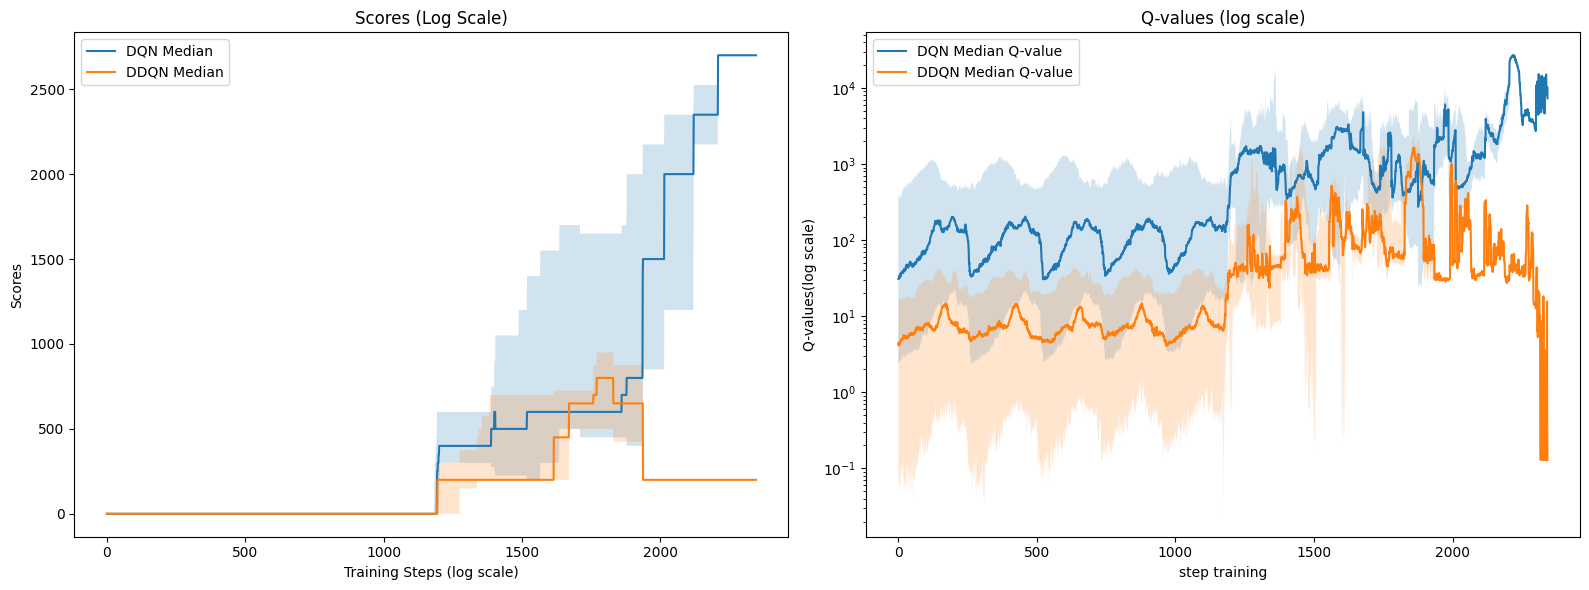

In [ ]:

# Lancer l'entraînement
train_and_plot(
    env_name="Zaxxon-v4",
    num_episodes=100,
    num_runs=3,
    EPS_START=0.9,
    EPS_END=0.1,
    EPS_DECAY=5000,
    BATCH_SIZE=128,
    GAMMA=0.99,
    TAU=0.001
)

Epoch de l'entrainement: 0
Epoch de l'entrainement: 1
Epoch de l'entrainement: 2
Epoch de l'entrainement: 3
Epoch de l'entrainement: 4
Epoch de l'entrainement: 5
Epoch de l'entrainement: 6
Epoch de l'entrainement: 7
Epoch de l'entrainement: 8
Epoch de l'entrainement: 9
Epoch de l'entrainement: 10
Epoch de l'entrainement: 11
Epoch de l'entrainement: 12
Epoch de l'entrainement: 13
Epoch de l'entrainement: 14
Epoch de l'entrainement: 15
Epoch de l'entrainement: 16
Epoch de l'entrainement: 17
Epoch de l'entrainement: 18
Epoch de l'entrainement: 19
Epoch de l'entrainement: 20
Epoch de l'entrainement: 21
Epoch de l'entrainement: 22
Epoch de l'entrainement: 23
Epoch de l'entrainement: 24
Epoch de l'entrainement: 25
Epoch de l'entrainement: 26
Epoch de l'entrainement: 27
Epoch de l'entrainement: 28
Epoch de l'entrainement: 29
Epoch de l'entrainement: 30
Epoch de l'entrainement: 31
Epoch de l'entrainement: 32
Epoch de l'entrainement: 33
Epoch de l'entrainement: 34
Epoch de l'entrainement: 35
Ep

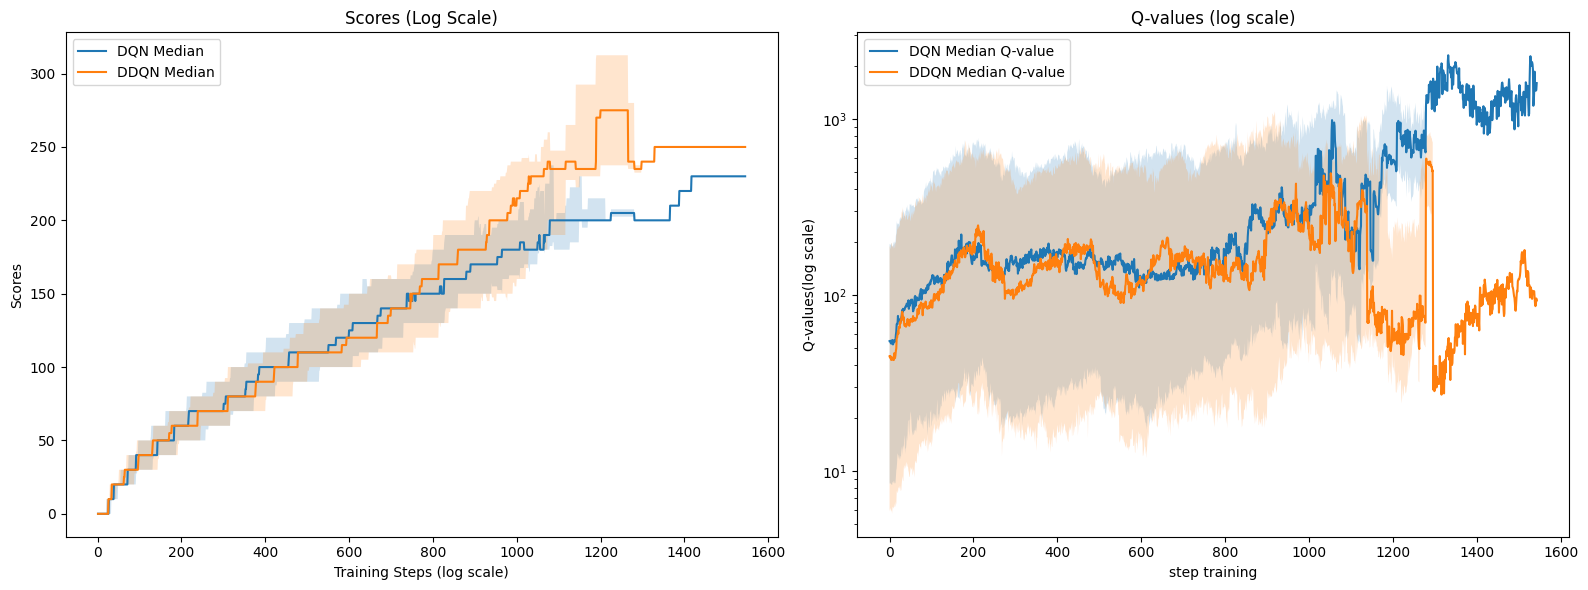

In [16]:
# Lancer l'entraînement
train_and_plot(
    env_name="Alien-v4",
    num_episodes=100,
    num_runs=1,
    EPS_START=1.0,
    EPS_END=0.1,
    EPS_DECAY=5000,
    BATCH_SIZE=32,
    GAMMA=0.99,
    TAU=0.001
)

Epoch de l'entrainement: 0
Epoch de l'entrainement: 1
Epoch de l'entrainement: 2
Epoch de l'entrainement: 3
Epoch de l'entrainement: 4
Epoch de l'entrainement: 5
Epoch de l'entrainement: 6
Epoch de l'entrainement: 7
Epoch de l'entrainement: 8
Epoch de l'entrainement: 9
Epoch de l'entrainement: 10
Epoch de l'entrainement: 11
Epoch de l'entrainement: 12
Epoch de l'entrainement: 13
Epoch de l'entrainement: 14
Epoch de l'entrainement: 15
Epoch de l'entrainement: 16
Epoch de l'entrainement: 17
Epoch de l'entrainement: 18
Epoch de l'entrainement: 19
Epoch de l'entrainement: 20
Epoch de l'entrainement: 21
Epoch de l'entrainement: 22
Epoch de l'entrainement: 23
Epoch de l'entrainement: 24
Epoch de l'entrainement: 25
Epoch de l'entrainement: 26
Epoch de l'entrainement: 27
Epoch de l'entrainement: 28
Epoch de l'entrainement: 29
Epoch de l'entrainement: 30
Epoch de l'entrainement: 31
Epoch de l'entrainement: 32
Epoch de l'entrainement: 33
Epoch de l'entrainement: 34
Epoch de l'entrainement: 35
Ep

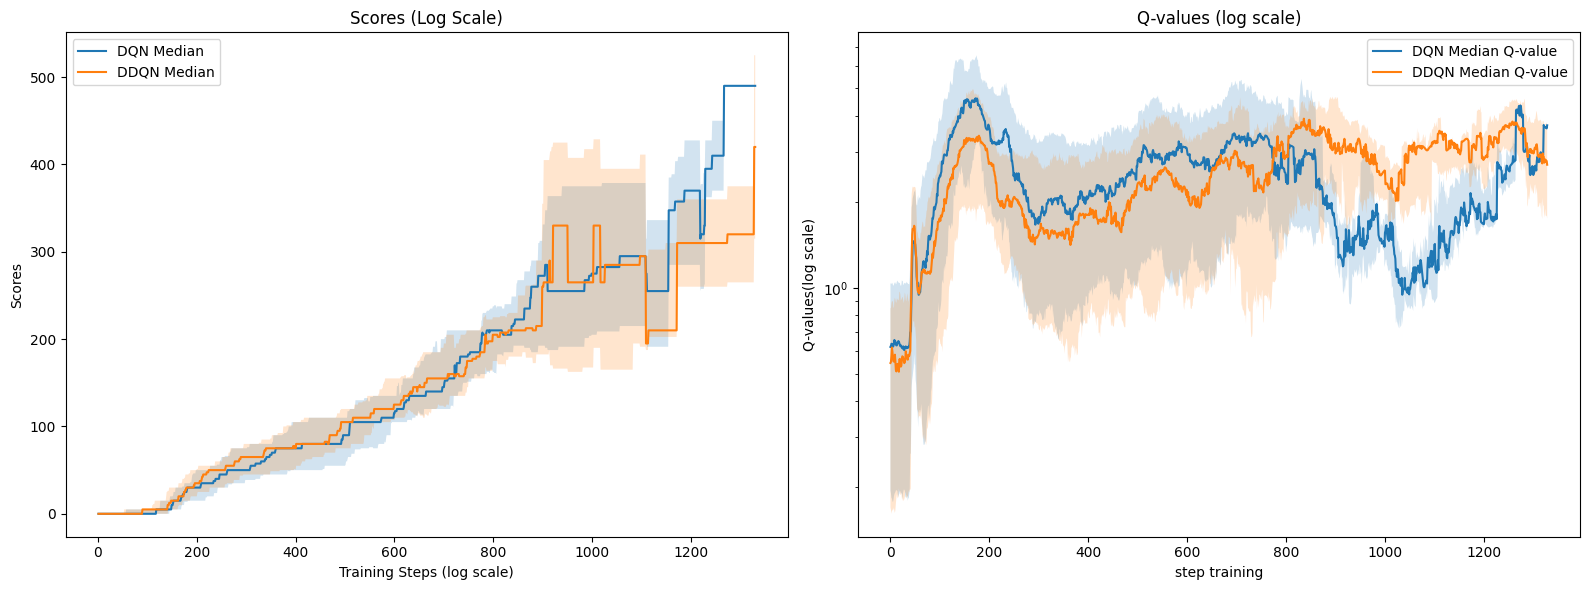

In [19]:
# Lancer l'entraînement
train_and_plot(
    env_name="SpaceInvaders-v4",
    num_episodes=100,
    num_runs=1,
    EPS_START=1.0,
    EPS_END=0.1,
    EPS_DECAY=5000,
    BATCH_SIZE=32,
    GAMMA=0.99,
    TAU=0.001
)

Epoch de l'entrainement: 0
Epoch de l'entrainement: 1
Epoch de l'entrainement: 2
Epoch de l'entrainement: 3
Epoch de l'entrainement: 4
Epoch de l'entrainement: 5
Epoch de l'entrainement: 6
Epoch de l'entrainement: 7
Epoch de l'entrainement: 8
Epoch de l'entrainement: 9
Epoch de l'entrainement: 10
Epoch de l'entrainement: 11
Epoch de l'entrainement: 12
Epoch de l'entrainement: 13
Epoch de l'entrainement: 14
Epoch de l'entrainement: 15
Epoch de l'entrainement: 16
Epoch de l'entrainement: 17
Epoch de l'entrainement: 18
Epoch de l'entrainement: 19
Epoch de l'entrainement: 20
Epoch de l'entrainement: 21
Epoch de l'entrainement: 22
Epoch de l'entrainement: 23
Epoch de l'entrainement: 24
Epoch de l'entrainement: 25
Epoch de l'entrainement: 26
Epoch de l'entrainement: 27
Epoch de l'entrainement: 28
Epoch de l'entrainement: 29
Epoch de l'entrainement: 30
Epoch de l'entrainement: 31
Epoch de l'entrainement: 32
Epoch de l'entrainement: 33
Epoch de l'entrainement: 34
Epoch de l'entrainement: 35
Ep

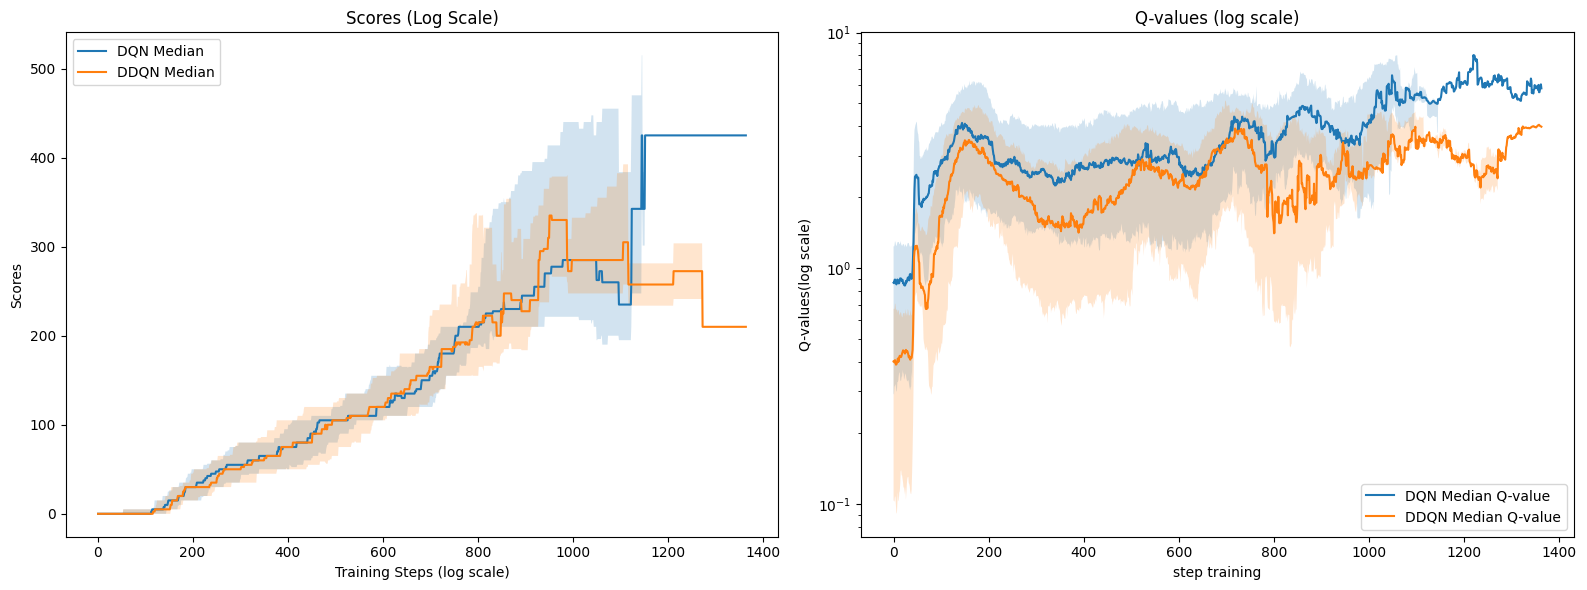

In [20]:
# Lancer l'entraînement
train_and_plot(
    env_name="SpaceInvaders-v4",
    num_episodes=100,
    num_runs=1,
    EPS_START=1.0,
    EPS_END=0.1,
    EPS_DECAY=5000,
    BATCH_SIZE=32,
    GAMMA=0.99,
    TAU=0.001
)

##Visualisation on average on  training steps

In [ ]:


def plot_results(scores_dqn_runs, scores_ddqn_runs, q_values_dqn_run, q_values_ddqn_run):
    """
    Affiche les résultats d'entraînement des algorithmes DQN et DDQN, en traçant les scores d'entraînement et les valeurs Q.

    Cette fonction génère deux graphiques pour comparer les performances des algorithmes DQN et DDQN au cours de l'entraînement.
    - Le premier graphique montre l'évolution des scores d'entraînement, sur une échelle logarithmique, en incluant les médianes et les intervalles de confiance (25ème et 75ème percentiles).
    - Le deuxième graphique présente l'évolution des valeurs Q moyennes, également sur une échelle logarithmique, avec des intervalles de confiance.

    Args:
    - scores_dqn_runs (list of list of float): Les scores obtenus pendant l'entraînement de DQN, par épisode.
    - scores_ddqn_runs (list of list of float): Les scores obtenus pendant l'entraînement de DDQN, par épisode.
    - q_values_dqn_run (list of list of float): Les valeurs Q calculées pendant l'entraînement de DQN, par étape d'entraînement.
    - q_values_ddqn_run (list of list of float): Les valeurs Q calculées pendant l'entraînement de DDQN, par étape d'entraînement.
    """

    #print("scores_dqn_runs",scores_dqn_runs)

    # Appliquer le padding aux Q-values
    q_values_dqn_run = pad_sequences(q_values_dqn_run)
    q_values_ddqn_run = pad_sequences(q_values_ddqn_run)
    scores_dqn_runs = pad_sequences(scores_dqn_runs)
    scores_ddqn_runs = pad_sequences(scores_ddqn_runs)
    #scores
    median_dqn = np.nanmedian(scores_dqn_runs, axis=0)
    lower_dqn = np.nanpercentile(scores_dqn_runs, 25, axis=0)
    upper_dqn = np.nanpercentile(scores_dqn_runs, 75, axis=0)

    median_ddqn = np.nanmedian(scores_ddqn_runs, axis=0)
    lower_ddqn = np.nanpercentile(scores_ddqn_runs, 25, axis=0)
    upper_ddqn = np.nanpercentile(scores_ddqn_runs, 75, axis=0)
    #q_values

    # Calculer les médianes en ignorant les NaN
    median_dqn_q = np.nanmedian(q_values_dqn_run, axis=0)
    lower_dqn_q = np.nanpercentile(q_values_dqn_run, 25, axis=0)
    upper_dqn_q = np.nanpercentile(q_values_dqn_run, 75, axis=0)

    median_ddqn_q = np.nanmedian(q_values_ddqn_run, axis=0)
    lower_ddqn_q = np.nanpercentile(q_values_ddqn_run, 25, axis=0)
    upper_ddqn_q = np.nanpercentile(q_values_ddqn_run, 75, axis=0)

    num_episodes_scores = min(len(scores_dqn_runs[0]),len(scores_ddqn_runs[0]))  #
    num_episodes_scores = min(len(scores_dqn_runs[0]),len(scores_ddqn_runs[0]))  #
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

    # Premier graphe : Scores
    x_range_scores = range(1, min(len(median_dqn), len(median_ddqn)) + 1)
    axs[0].plot(x_range_scores, median_dqn[:len(x_range_scores)], label='DQN Median')
    axs[0].fill_between(x_range_scores, lower_dqn[:len(x_range_scores)], upper_dqn[:len(x_range_scores)], alpha=0.2)
    axs[0].plot(x_range_scores, median_ddqn[:len(x_range_scores)], label='DDQN Median')
    axs[0].fill_between(x_range_scores, lower_ddqn[:len(x_range_scores)], upper_ddqn[:len(x_range_scores)], alpha=0.2)
    # Titre et labels
    axs[0].set_title('Scores (Log Scale)')
    axs[0].set_xlabel('Training Steps (log scale)')
    axs[0].set_ylabel('Scores')
    axs[0].set_yscale('log')

    # Appliquer l'échelle logarithmique sur l'axe x
    #axs[0].set_xscale('log')

    axs[0].legend()

    # Deuxième graphe : Q-values
    x_range_q = range(min(len(median_dqn_q), len(median_ddqn_q)))
    axs[1].plot(x_range_q, median_dqn_q[:len(x_range_q)], label='DQN Median Q-value')
    axs[1].fill_between(x_range_q, lower_dqn_q[:len(x_range_q)], upper_dqn_q[:len(x_range_q)], alpha=0.2)
    axs[1].plot(x_range_q, median_ddqn_q[:len(x_range_q)], label='DDQN Median Q-value')
    axs[1].fill_between(x_range_q, lower_ddqn_q[:len(x_range_q)], upper_ddqn_q[:len(x_range_q)], alpha=0.2)
    axs[1].set_title('Q-values (log scale)')
    axs[1].set_xlabel('step training')
    axs[1].set_ylabel('Q-values(log scale)')
    axs[1].set_yscale('log')
    axs[1].legend()

    # Ajuster l'espacement
    plt.tight_layout()
    plt.show()


##Training and plot

In [ ]:

# Fonction principale d'entraînement
def train_and_plot(env_name, num_episodes, num_runs, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA, TAU):
    """
    Entraîne et évalue les algorithmes DQN et DDQN sur un environnement OpenAI Gym, puis affiche les résultats sous forme de graphiques.

    Cette fonction entraîne les algorithmes DQN et DDQN pendant plusieurs épisodes et exécutions. À chaque épisode, les scores et les valeurs Q sont collectés pour chaque algorithme.
    Les résultats sont ensuite visualisés à l'aide des graphiques générés par la fonction `plot_results`.

    Args:
    - env_name (str): Le nom de l'environnement Gym à utiliser pour l'entraînement.
    - num_episodes (int): Le nombre d'épisodes d'entraînement pour chaque exécution.
    - num_runs (int): Le nombre d'exécutions à effectuer pour chaque algorithme.
    - EPS_START (float): La valeur initiale de l'epsilon pour l'exploration.
    - EPS_END (float): La valeur finale de l'epsilon.
    - EPS_DECAY (float): Le facteur de décroissance de l'epsilon.
    - BATCH_SIZE (int): La taille du lot pour l'entraînement par mini-batch.
    - GAMMA (float): Le facteur de discount pour le calcul de la récompense future.
    - TAU (float): Le facteur de mise à jour des poids du réseau cible (soft update).

    Returns:
    - None: La fonction entraîne les réseaux, collecte les résultats et les affiche sous forme de graphiques.
    """

    env = gym.make(env_name, render_mode="rgb_array")
    n_actions = env.action_space.n
    init_screen = env.reset()[0]
    _, _, screen_height, screen_width = preprocess_observation(init_screen).shape

    scores_dqn_runs, scores_ddqn_runs = [], []
    q_values_dqn_run, q_values_ddqn_run = [], []
    iteration_run=[]

    for run in range(num_runs):
        print(f"Run: {run+1}/{num_runs}")
        set_seed(run)
        # Initialisation des réseaux DQN
        policy_net_dqn = DQN(screen_height, screen_width, n_actions).to(device)
        target_net_dqn = DQN(screen_height, screen_width, n_actions).to(device)
        target_net_dqn.load_state_dict(policy_net_dqn.state_dict())
        target_net_dqn.eval()
        optimizer_dqn = optim.AdamW(policy_net_dqn.parameters(), lr=1e-4, amsgrad=True)
        memory_dqn = ReplayMemory(10000)

        # Initialisation des réseaux DDQN
        policy_net_ddqn = DQN(screen_height, screen_width, n_actions).to(device)
        target_net_ddqn = DQN(screen_height, screen_width, n_actions).to(device)
        target_net_ddqn.load_state_dict(policy_net_ddqn.state_dict())
        target_net_ddqn.eval()
        optimizer_ddqn = optim.AdamW(policy_net_ddqn.parameters(), lr=1e-4, amsgrad=True)
        memory_ddqn = ReplayMemory(10000)

        scores_dqn, scores_ddqn = [], []
        q_values_dqn, q_values_ddqn = [], []
        iteration=[]

        for episode in range(num_episodes):
            print("Epoch de l'entrainement:",episode)
            # Entraînement DQN

            dqn_score, dqn_q_values ,rewards= train_episode(env, policy_net_dqn, target_net_dqn, optimizer_dqn, memory_dqn, n_actions,0, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU ,use_ddqn=False)
            scores_dqn.append(np.sum(rewards))
            q_values_dqn.append(np.mean(dqn_q_values))

            # Entraînement DDQN
            ddqn_score, ddqn_q_values,rewards_ddqn = train_episode(env, policy_net_ddqn, target_net_ddqn, optimizer_ddqn, memory_ddqn, n_actions, 0, EPS_START, EPS_END, EPS_DECAY, BATCH_SIZE, GAMMA,TAU, use_ddqn=True)
            scores_ddqn.append(np.sum(rewards_ddqn))
            q_values_ddqn.append(np.mean(ddqn_q_values))
        #print("q_values",q_values_ddqn)

        scores_dqn_runs.append(scores_dqn)
        scores_ddqn_runs.append(scores_ddqn)
        q_values_dqn_run.append(q_values_dqn)
        q_values_ddqn_run.append(q_values_ddqn)
    print("q_runs",q_values_dqn_run)
    # Plotting
    plot_results(scores_dqn_runs, scores_ddqn_runs, q_values_dqn_run, q_values_ddqn_run)

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `Alien-v4` instead of the unversioned environment `Alien`.
  logger.warn(


Run: 1/1
Epoch de l'entrainement: 0
Epoch de l'entrainement: 1
Epoch de l'entrainement: 2
Epoch de l'entrainement: 3
Epoch de l'entrainement: 4
Epoch de l'entrainement: 5
Epoch de l'entrainement: 6
Epoch de l'entrainement: 7
Epoch de l'entrainement: 8
Epoch de l'entrainement: 9
Epoch de l'entrainement: 10
Epoch de l'entrainement: 11
Epoch de l'entrainement: 12
Epoch de l'entrainement: 13
Epoch de l'entrainement: 14
Epoch de l'entrainement: 15
Epoch de l'entrainement: 16
Epoch de l'entrainement: 17
Epoch de l'entrainement: 18
Epoch de l'entrainement: 19
Epoch de l'entrainement: 20
Epoch de l'entrainement: 21
Epoch de l'entrainement: 22
Epoch de l'entrainement: 23
Epoch de l'entrainement: 24
Epoch de l'entrainement: 25
Epoch de l'entrainement: 26
Epoch de l'entrainement: 27
Epoch de l'entrainement: 28
Epoch de l'entrainement: 29
Epoch de l'entrainement: 30
Epoch de l'entrainement: 31
Epoch de l'entrainement: 32
Epoch de l'entrainement: 33
Epoch de l'entrainement: 34
Epoch de l'entraineme

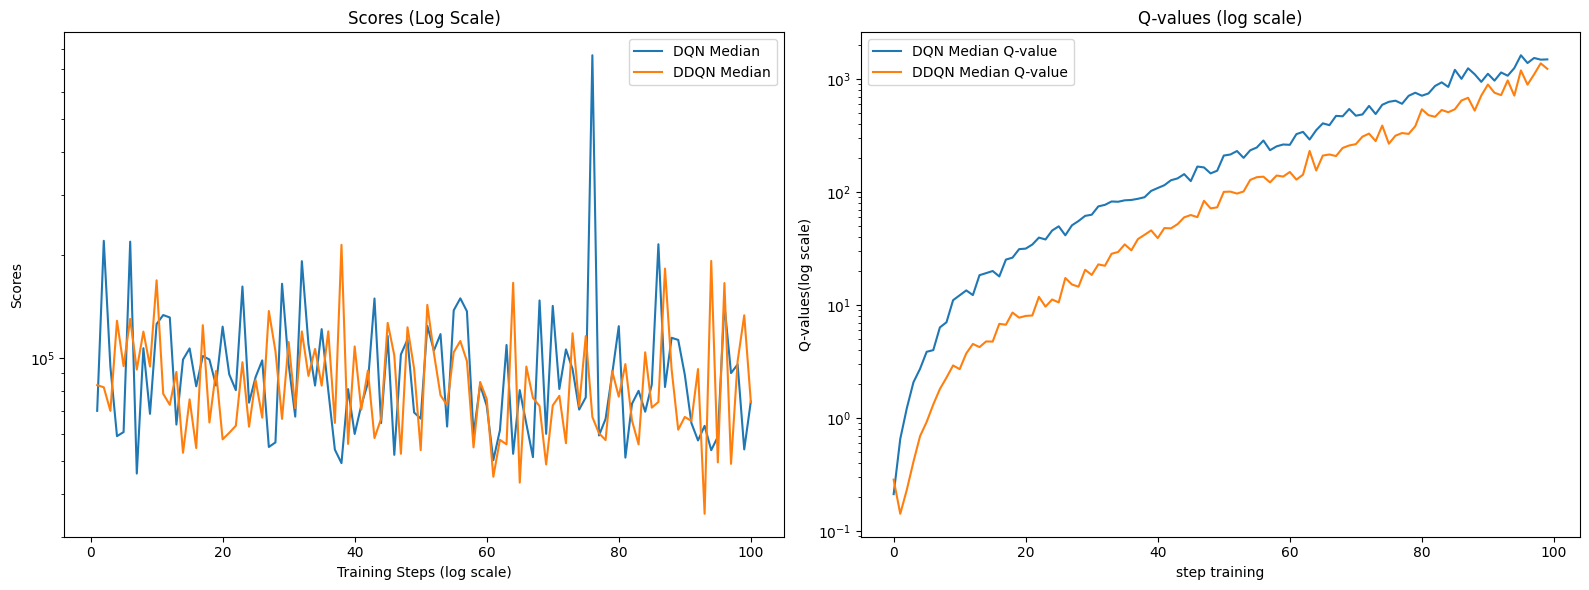

In [ ]:
# Lancer l'entraînement
train_and_plot(
    env_name="Alien",
    num_episodes=100,
    num_runs=1,
    EPS_START=1.0,
    EPS_END=0.1,
    EPS_DECAY=5000,
    BATCH_SIZE=32,
    GAMMA=0.99,
    TAU=0.001
)


Run: 1/1
Epoch de l'entrainement: 0
Epoch de l'entrainement: 1
Epoch de l'entrainement: 2
Epoch de l'entrainement: 3
Epoch de l'entrainement: 4
Epoch de l'entrainement: 5
Epoch de l'entrainement: 6
Epoch de l'entrainement: 7
Epoch de l'entrainement: 8
Epoch de l'entrainement: 9
Epoch de l'entrainement: 10
Epoch de l'entrainement: 11
Epoch de l'entrainement: 12
Epoch de l'entrainement: 13
Epoch de l'entrainement: 14
Epoch de l'entrainement: 15
Epoch de l'entrainement: 16
Epoch de l'entrainement: 17
Epoch de l'entrainement: 18
Epoch de l'entrainement: 19
Epoch de l'entrainement: 20
Epoch de l'entrainement: 21
Epoch de l'entrainement: 22
Epoch de l'entrainement: 23
Epoch de l'entrainement: 24
Epoch de l'entrainement: 25
Epoch de l'entrainement: 26
Epoch de l'entrainement: 27
Epoch de l'entrainement: 28
Epoch de l'entrainement: 29
Epoch de l'entrainement: 30
Epoch de l'entrainement: 31
Epoch de l'entrainement: 32
Epoch de l'entrainement: 33
Epoch de l'entrainement: 34
Epoch de l'entraineme

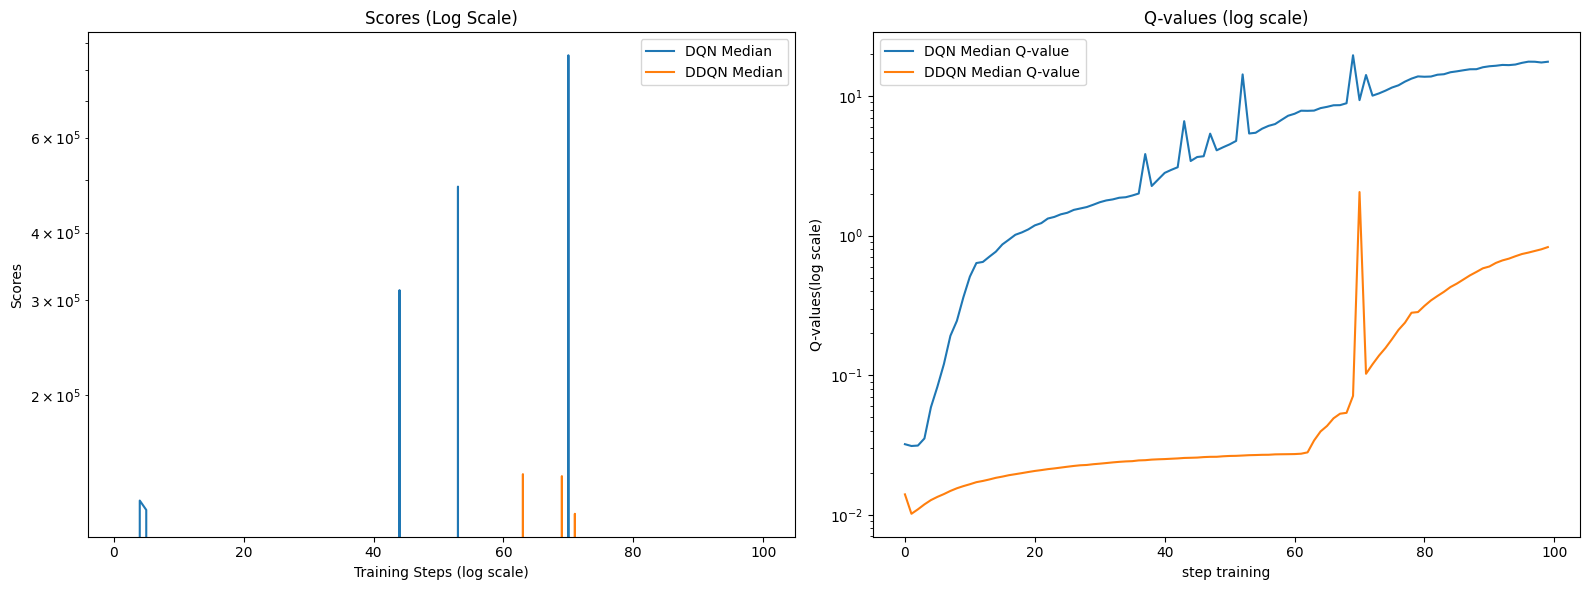

In [ ]:
# Lancer l'entraînement
train_and_plot(
    env_name="Zaxxon-v4",
    num_episodes=100,
    num_runs=1,
    EPS_START=1.0,
    EPS_END=0.1,
    EPS_DECAY=5000,
    BATCH_SIZE=32,
    GAMMA=0.99,
    TAU=0.001
)


Run: 1/1
Epoch de l'entrainement: 0
Epoch de l'entrainement: 1
Epoch de l'entrainement: 2
Epoch de l'entrainement: 3
Epoch de l'entrainement: 4
Epoch de l'entrainement: 5
Epoch de l'entrainement: 6
Epoch de l'entrainement: 7
Epoch de l'entrainement: 8
Epoch de l'entrainement: 9
Epoch de l'entrainement: 10
Epoch de l'entrainement: 11
Epoch de l'entrainement: 12
Epoch de l'entrainement: 13
Epoch de l'entrainement: 14
Epoch de l'entrainement: 15
Epoch de l'entrainement: 16
Epoch de l'entrainement: 17
Epoch de l'entrainement: 18
Epoch de l'entrainement: 19
Epoch de l'entrainement: 20
Epoch de l'entrainement: 21
Epoch de l'entrainement: 22
Epoch de l'entrainement: 23
Epoch de l'entrainement: 24
Epoch de l'entrainement: 25
Epoch de l'entrainement: 26
Epoch de l'entrainement: 27
Epoch de l'entrainement: 28
Epoch de l'entrainement: 29
Epoch de l'entrainement: 30
Epoch de l'entrainement: 31
Epoch de l'entrainement: 32
Epoch de l'entrainement: 33
Epoch de l'entrainement: 34
Epoch de l'entraineme

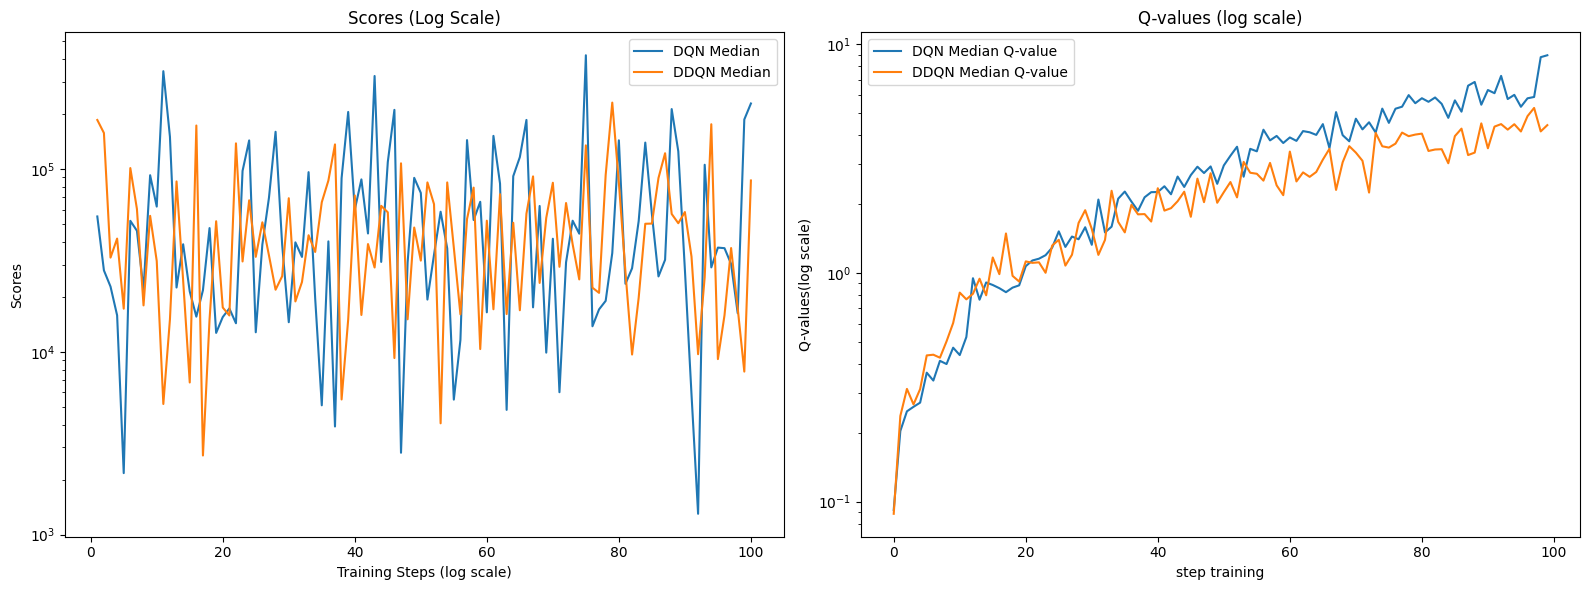

In [ ]:
# Lancer l'entraînement
train_and_plot(
    env_name="SpaceInvaders-v4",
    num_episodes=100,
    num_runs=1,
    EPS_START=1.0,
    EPS_END=0.1,
    EPS_DECAY=5000,
    BATCH_SIZE=32,
    GAMMA=0.99,
    TAU=0.001
)
